In [ ]:
!pip install pandas numpy scikit-learn imbalanced-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE  # For handling class imbalance

# Data Pre-Processing

In [ ]:
# Load the dataset (replace 'unsw_nb15.csv' with your file path)
data = pd.read_csv('/content/train_test_network(in).csv')

In [ ]:
# Replace '-' with NaN for consistency
data.replace('-', np.nan, inplace=True)

In [ ]:
# Drop columns with >90% missing values (optional, adjust threshold as needed)
data = data.dropna(thresh=len(data) * 0.1, axis=1)

In [ ]:
# Printing first 5 columns
data.head()

,src_ip,src_port,dst_ip,dst_port,proto,service,duration,src_bytes,dst_bytes,conn_state,...,dns_rcode,dns_AA,dns_RD,dns_RA,dns_rejected,http_request_body_len,http_response_body_len,http_status_code,label,type
0,192.168.1.37,4444,192.168.1.193,49178,tcp,NaN,290.371539,101568,2592,OTH,...,0,NaN,NaN,NaN,NaN,0,0,0,1,backdoor
1,192.168.1.193,49180,192.168.1.37,8080,tcp,NaN,0.000102,0,0,REJ,...,0,NaN,NaN,NaN,NaN,0,0,0,1,backdoor
2,192.168.1.193,49180,192.168.1.37,8080,tcp,NaN,0.000148,0,0,REJ,...,0,NaN,NaN,NaN,NaN,0,0,0,1,backdoor
3,192.168.1.193,49180,192.168.1.37,8080,tcp,NaN,0.000113,0,0,REJ,...,0,NaN,NaN,NaN,NaN,0,0,0,1,backdoor
4,192.168.1.193,49180,192.168.1.37,8080,tcp,NaN,0.000130,0,0,REJ,...,0,NaN,NaN,NaN,NaN,0,0,0,1,backdoor


In [ ]:
# Define feature columns (exclude target and IP addresses for simplicity)
# IPs can be feature-engineered (e.g., subnet) if needed, but omitted here
feature_cols = [col for col in data.columns if col not in ['src_ip', 'dst_ip', 'label', 'type']]
X = data[feature_cols]
y = data['type']  # Multi-class target (e.g., 'backdoor', 'normal', etc.)

In [ ]:
# Preprocess categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X[col] = X[col].fillna('Unknown')  # Fill nulls with 'Unknown'
    X[col] = LabelEncoder().fit_transform(X[col])  # Encode to numerical

# Preprocess numerical columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    X[col] = X[col].fillna(X[col].mean())  # Fill nulls with column mean

<ipython-input-11-d5e826aba76b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].fillna('Unknown')  # Fill nulls with 'Unknown'
<ipython-input-11-d5e826aba76b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = LabelEncoder().fit_transform(X[col])  # Encode to numerical
<ipython-input-11-d5e826aba76b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

# Scaling and Splitting

In [ ]:
# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

<ipython-input-12-1e19c49cf2ca>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


In [ ]:
# Encode target variable
y = LabelEncoder().fit_transform(y)

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Handle class imbalance with SMOTE (optional, improves performance for rare classes)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Training Random Forest

In [ ]:
# Train Random Forest model
model = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    max_depth=20,           # Limit depth for efficiency
    min_samples_split=5,    # Prevent overfitting
    n_jobs=-1,              # Use all CPU cores
    random_state=42
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_split=5, n_jobs=-1,
                       random_state=42)

In [ ]:
# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=LabelEncoder().fit(data['type']).classes_))

Accuracy: 0.9889597005378
Classification Report:
              precision    recall  f1-score   support

    backdoor       1.00      1.00      1.00      3919
        ddos       0.99      0.98      0.98      4065
         dos       1.00      0.98      0.99      3934
   injection       0.98      0.97      0.97      3978
        mitm       0.59      0.93      0.72       213
      normal       1.00      1.00      1.00     10021
    password       1.00      0.99      0.99      3968
  ransomware       1.00      1.00      1.00      4047
    scanning       0.99      0.99      0.99      4015
         xss       0.97      0.99      0.98      4049

    accuracy                           0.99     42209
   macro avg       0.95      0.98      0.96     42209
weighted avg       0.99      0.99      0.99     42209



In [ ]:
# Feature importance (optional, for interpretability)
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nTop 10 Feature Importances:")
print(feature_importance.head(10))


Top 10 Feature Importances:
         Feature  Importance
10  src_ip_bytes    0.165135
1       dst_port    0.111517
0       src_port    0.107871
7     conn_state    0.095049
4       duration    0.093405
12  dst_ip_bytes    0.079429
5      src_bytes    0.069557
9       src_pkts    0.069402
11      dst_pkts    0.060913
6      dst_bytes    0.040724


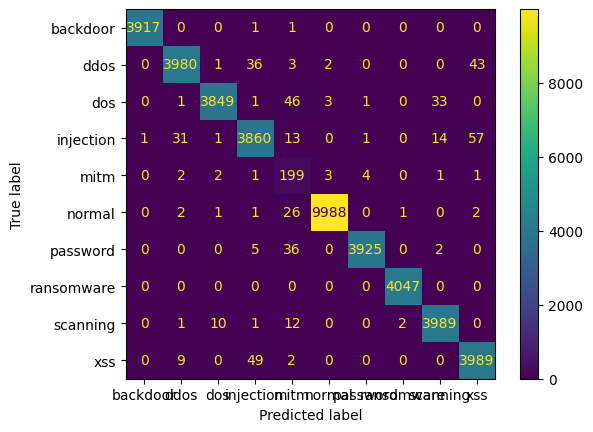

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred) # Changed y_pred_rf to y_pred
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=LabelEncoder().fit(data['type']).classes_) # Added display_labels
disp_rf.plot()
plt.show()


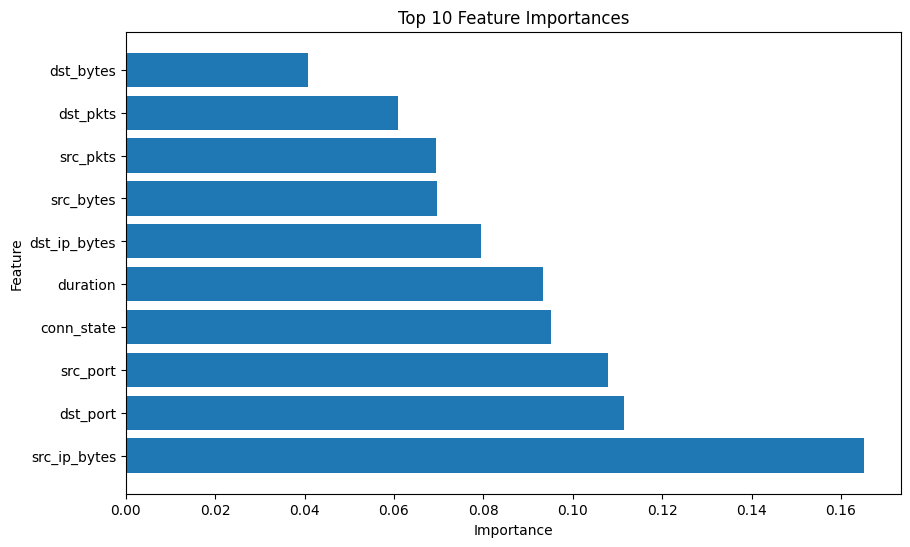

In [ ]:
# Feature Importance Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'].head(10), feature_importance['Importance'].head(10))
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.show()

# Testing Random forest model with sample data

In [ ]:
import pandas as pd

# Sample data (excluding label and type for prediction input)
sample = {
    'src_port': 4444,
    'dst_port': 49178,
    'proto': 'tcp',
    'service': None,  # NaN
    'duration': 290.371539,
    'src_bytes': 101568,
    'dst_bytes': 2592,
    'conn_state': 'OTH',
    # Add other columns as needed (e.g., dns_rcode, etc.)
    'dns_rcode': 0,
    'dns_AA': None,
    'dns_RD': None,
    'dns_RA': None,
    'dns_rejected': None,
    'http_request_body_len': 0,
    'http_response_body_len': 0,
    'http_status_code': 0
    # ... add other features used during training, ensuring the same names ...
}

# Convert to DataFrame
X_sample = pd.DataFrame([sample])

In [ ]:
X_sample = X_sample.reindex(columns=X_train.columns, fill_value=0) # Reindex to match training data columns

# Preprocess categorical columns
categorical_cols = X_sample.select_dtypes(include=['object']).columns
for col in categorical_cols:
    X_sample[col] = X_sample[col].fillna('Unknown')  # Fill nulls with 'Unknown'
    # Use the same LabelEncoder fitted on X_train (if available)
    # Assuming you saved the LabelEncoders during training, use them here.
    # If not, you'll need to refit them using X_train data.
    # Example: X_sample[col] = label_encoders[col].transform(X_sample[col])
    X_sample[col] = LabelEncoder().fit_transform(X_sample[col])  # Encode to numerical

# Preprocess numerical columns
numerical_cols = X_sample.select_dtypes(include=['int64', 'float64']).columns
for col in numerical_cols:
    X_sample[col] = X_sample[col].fillna(X_sample[col].mean())  # Fill nulls with mean


In [ ]:
# Predict the label
prediction = model.predict(X_sample)
print("Predicted label:", prediction[0])

# Optionally, get prediction probabilities
probabilities = model.predict_proba(X_sample)
print("Prediction probabilities:", probabilities[0])

Predicted label: 4
Prediction probabilities: [0.05       0.16878571 0.0125     0.0225     0.33666667 0.325
 0.         0.         0.01       0.07454762]


In [ ]:
label_encoder = LabelEncoder().fit(data['type']) # Assuming 'data' is your original DataFrame
class_names = label_encoder.classes_
print(class_names)
print(class_names[5]) # Get the class name corresponding to label 5

['backdoor' 'ddos' 'dos' 'injection' 'mitm' 'normal' 'password'
 'ransomware' 'scanning' 'xss']
normal


# Training Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Handle class imbalance with SMOTE (optional, improves performance for rare classes)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
model_dt = DecisionTreeClassifier(random_state=42)
model_dt.fit(X_train, y_train)
y_pred_dt = model_dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt, target_names=LabelEncoder().fit(data['type']).classes_))

Decision Tree Accuracy: 0.9866379208225734
Decision Tree Classification Report:
              precision    recall  f1-score   support

    backdoor       1.00      1.00      1.00      3919
        ddos       0.98      0.98      0.98      4065
         dos       0.99      0.98      0.98      3934
   injection       0.96      0.97      0.97      3978
        mitm       0.67      0.78      0.72       213
      normal       1.00      1.00      1.00     10021
    password       0.99      0.99      0.99      3968
  ransomware       1.00      1.00      1.00      4047
    scanning       0.99      0.99      0.99      4015
         xss       0.98      0.97      0.97      4049

    accuracy                           0.99     42209
   macro avg       0.96      0.97      0.96     42209
weighted avg       0.99      0.99      0.99     42209



# Training Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Handle class imbalance with SMOTE (optional, improves performance for rare classes)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
model_gb = GradientBoostingClassifier(random_state=42)
model_gb.fit(X_train, y_train)
y_pred_gb = model_gb.predict(X_test)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb}")
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb, target_names=LabelEncoder().fit(data['type']).classes_))


Gradient Boosting Accuracy: 0.9837475419934137
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

    backdoor       1.00      1.00      1.00      3919
        ddos       0.98      0.96      0.97      4065
         dos       1.00      0.97      0.99      3934
   injection       0.97      0.96      0.96      3978
        mitm       0.48      0.95      0.63       213
      normal       1.00      0.99      0.99     10021
    password       1.00      0.99      0.99      3968
  ransomware       1.00      1.00      1.00      4047
    scanning       0.99      0.99      0.99      4015
         xss       0.97      0.98      0.97      4049

    accuracy                           0.98     42209
   macro avg       0.94      0.98      0.95     42209
weighted avg       0.99      0.98      0.98     42209



# Training K-Nearest Neighbours

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Handle class imbalance with SMOTE (optional, improves performance for rare classes)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNN Accuracy: {accuracy_knn}")
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn, target_names=LabelEncoder().fit(data['type']).classes_))


KNN Accuracy: 0.9753607050629013
KNN Classification Report:
              precision    recall  f1-score   support

    backdoor       1.00      1.00      1.00      3919
        ddos       0.97      0.96      0.96      4065
         dos       0.98      0.98      0.98      3934
   injection       0.95      0.95      0.95      3978
        mitm       0.46      0.87      0.60       213
      normal       1.00      0.99      0.99     10021
    password       0.98      0.97      0.97      3968
  ransomware       0.99      0.99      0.99      4047
    scanning       0.98      0.98      0.98      4015
         xss       0.95      0.95      0.95      4049

    accuracy                           0.98     42209
   macro avg       0.93      0.96      0.94     42209
weighted avg       0.98      0.98      0.98     42209



# Training Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Handle class imbalance with SMOTE (optional, improves performance for rare classes)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr, target_names=LabelEncoder().fit(data['type']).classes_))


Logistic Regression Accuracy: 0.765239640834893
Logistic Regression Classification Report:
              precision    recall  f1-score   support

    backdoor       0.67      0.99      0.80      3919
        ddos       0.74      0.83      0.78      4065
         dos       0.97      0.92      0.95      3934
   injection       0.73      0.66      0.69      3978
        mitm       0.14      0.74      0.24       213
      normal       0.99      0.81      0.89     10021
    password       0.64      0.50      0.56      3968
  ransomware       0.54      0.65      0.59      4047
    scanning       0.87      0.69      0.77      4015
         xss       0.79      0.77      0.78      4049

    accuracy                           0.77     42209
   macro avg       0.71      0.76      0.70     42209
weighted avg       0.80      0.77      0.77     42209



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
